In [ ]:
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import FloatTensor
from torch.autograd import Variable
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
with open('/content/drive/MyDrive/mixology_cocktails.json') as f:
    d = json.load(f)

In [ ]:
data = pd.DataFrame.from_dict(d).T.reset_index(drop=True).drop(['name', 'similar', 'notes'], axis=1)

In [ ]:
data['ing_id'] = data['ingredients'].apply(lambda x: [int(i['id']) for i in x])
data['ing_ml'] = data['ingredients'].apply(lambda x: [i['ml'] for i in x])
l = data['ing_id'].apply(len).max()

In [ ]:
data['ing_id'] = data['ing_id'].apply(lambda x: np.array(x + [0]*(10 - len(x))))
data['ing_ml'] = data['ing_ml'].apply(lambda x: np.array(x + [0]*(10 - len(x))))

In [ ]:
ids = torch.LongTensor(np.vstack(data['ing_id']))
rv = torch.FloatTensor(np.vstack(data['ing_ml']))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.emb = nn.Embedding(1000, 54)
        self.net = nn.Sequential(
            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.LayerNorm(1),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, data):
        ids, rvs = data
        embs = self.emb(ids).mean(1)
        seq = torch.cat([embs, rvs], axis=-1)
        p = self.net(seq)
        return p

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.LayerNorm(64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.LayerNorm(512),
            nn.ReLU(),

            nn.Linear(512, 1000),
            nn.LayerNorm(1000),
            nn.ReLU()
        )
        self.ids = nn.Linear(1000, 1000)
        self.rvs = nn.Linear(1000, 1)
    
    def forward(self, z):
        z = z.unsqueeze(-1)
        z = self.net(z)
        ids = self.ids(z)[:, :l, :].argmax(-1).squeeze(-1).squeeze(-1)
        rvs = self.rvs(z)[:, :l, :].squeeze(-1).squeeze(-1).squeeze(-1)
        return ids, rvs

In [ ]:
device = 'cuda'

In [ ]:
D = Discriminator().to(device)
G = Generator().to(device)

In [ ]:
criterion = nn.BCELoss()
nz = 64
b_size = 64
num_epochs = 100
real_label = 1.
fake_label = 0.

optimizerD = torch.optim.Adam(D.parameters())
optimizerG = torch.optim.Adam(G.parameters())

dataloader = list(zip(torch.split(ids, b_size), torch.split(rv, b_size)))

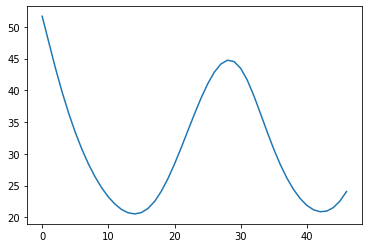

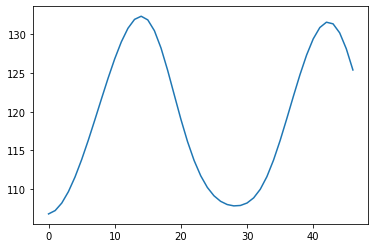

KeyboardInterrupt: ignored

In [ ]:
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    epochLossG = 0
    epochLossD = 0
    for data in dataloader:
        data = list(x.to(device) for x in data)
        bs =  data[0].size(0)
        labels = torch.full((bs,), 1, dtype=torch.float,
            device=device)
        output = D(data).view(-1)
        errorReal = criterion(output, labels)
        errorReal.backward()
        noise = torch.randn(bs, nz, device=device)
        fake = G(noise)
        labels.fill_(0)
        output = D(list(x.detach() for x in fake)).view(-1)
        errorFake = criterion(output, labels)
        errorFake.backward()
        errorD = errorReal + errorFake
        optimizerD.step()
        G.zero_grad()
        labels.fill_(1)
        output = D(fake).view(-1)
        errorG = criterion(output, labels)
        errorG.backward()
        optimizerG.step()
        epochLossD += errorD
        epochLossG += errorG

    G_losses.append(epochLossG.item())
    D_losses.append(epochLossD.item())
    clear_output(True)
    plt.plot(G_losses)
    plt.show()
    plt.plot(D_losses)
    plt.show()

In [ ]:
noise = torch.randn(bs, nz, device=device)

In [ ]:
generated = G(noise)

In [ ]:
ids = generated[0].cpu().detach().numpy()
rvs = generated[1].cpu().detach().numpy()

In [ ]:
D = pd.DataFrame.from_dict(d).T.reset_index(drop=True)
s = D['ingredients'].sum()

In [ ]:
def find(id):
    for i in s:
        if i['id'] == str(id):
            return i['text']

In [ ]:
for id, ml in zip(ids, rvs):
    string = []
    good = True
    for name, m in zip(id, ml):
        f = find(name)
        if f and f not in string:
            string.append(f"{f}")
    if good:
        print(", ".join(string))

Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink), Calvados (un trou normand)
Strawberry gin(gordon's pink), Calvados (un trou normand)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink), Calvados (un trou normand)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink), Calvados (un trou normand)
Strawberry gin(gordon's pink), Calvados (un trou normand)
Strawberry gin(gordon's pink), Calvados (un trou normand)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink)
Calvados (un trou normand), Strawberry gin(gordon's pink)
Calvados (un trou normand), Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink), Calvados (un trou normand)
Strawberry gin(gordon's pink)
Strawberry gin(gordon's pink), Calvados (un trou normand)
Strawberry gin(gordon's pink), Calvados (un trou normand)
St